In [ ]:
pip install emoji

In [ ]:
!pip install -q bitsandbytes
!pip install -q accelerate transformers peft

In [ ]:
pip install evaluate

In [9]:
from collections import Counter
from tqdm.auto import tqdm
import numpy as np
from collections import defaultdict
import re, json, torch, os
import emoji
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import torch
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
import evaluate
from tqdm import tqdm
import random

In [2]:
df_train = pd.read_csv('/content/train.csv')

In [3]:
df_train.head(5)

,text
0,"Заказали 14.10.2017 , получили 25.10.2017 \r\n..."
1,"футболка хорошего качества,но футболка не как ..."
2,Все отлично!!!
3,"Рисунок не очень чёткий, а ткань прозрачная, в..."
4,плохо!!!Низ рваный..деньги не вернули!Открыла ...


# Обзор датасета, сбор статистики, минимималистичный EDA

In [10]:
def quick_eda(df, text_col='text', n_samples=5):
  print('Row, cols:', df.shape)
  print('Missing text:', df[text_col].isna().sum())

  df['_len_words'] = df[text_col].fillna('').str.split().str.len()
  df['_len_chars'] = df[text_col].fillna('').str.len()

  print('\nTop 5 shortest examples:')
  display(df.nsmallest(5, '_len_words')[[text_col, '_len_words']])
  print('\nTop 5 longest examples:')
  display(df.nlargest(5, '_len_words')[[text_col, '_len_words']])

  dup = df.duplicated(subset=[text_col]).sum()
  print(f'\nDuplicated text rows: {dup}')

  toks = Counter()
  for t in df[text_col].dropna().astype(str).sample(min(2000, len(df))):
    toks.update(t.lower().split())
  print('\nTop tokens (sampled):', toks.most_common(30)[:30])

In [11]:
quick_eda(df_train)

Row, cols: (1818, 3)
Missing text: 0

Top 5 shortest examples:


,text,_len_words
102,Отлично!,1
305,Рекомендую.,1
395,Гавно,1
488,огонь!,1
567,Спасибо.,1



Top 5 longest examples:


,text,_len_words
697,"Брюки классные, полоса из кожзама, но мне прис...",41
17,"Товар так и не пришел. Заказала 6 июля, сейчас...",40
740,"ждала 60 с лишним дней, открыла спор чтобы хот...",40
26,"Я думала, что свитер будет более толстым , а н...",39
644,за 300 р. норм халат! на об 109 ог 109 хххл в ...,39



Duplicated text rows: 0

Top tokens (sampled): [('не', 1238), ('на', 795), ('и', 541), ('очень', 452), ('в', 398), ('но', 305), ('размер', 299), ('как', 194), ('товар', 187), ('качество', 187), ('по', 183), ('деньги', 175), ('с', 160), ('за', 155), ('так', 155), ('продавец', 144), ('что', 135), ('а', 133), ('все', 127), ('заказ', 121), ('я', 119), ('доставка', 106), ('ткань', 106), ('к', 101), (',', 99), ('соответствует', 96), ('рост', 87), ('платье', 85), ('заказала', 85), ('пришла', 76)]


*Top-токены показывают «размер», «качество», «доставка», «продавец» → видно, что будет немало случаев «нет товара» (например, про доставку/споры).*

Базовая очистка текста

In [12]:
URL_RE = re.compile(r'https?://\S+')
HTML_RE = re.compile(r'<[^>]+>')
EMAIL_RE = re.compile(r'\S+@\S+')
PHONE_RE = re.compile(r'\+?\d[\d\-\s]{5,}\d')

def clean_text(t: str) -> str:
  if pd.isna(t):
    return ''
  t = str(t)
  t = t.strip()
  t = URL_RE.sub(' ', t)
  t = HTML_RE.sub(' ', t)
  t = EMAIL_RE.sub(' ', t)
  t = PHONE_RE.sub(' ', t)
  t = emoji.replace_emoji(t, replace=' ')
  t = re.sub(r'\s+', ' ', t)
  return t

In [13]:
df_train['text_clean'] = df_train['text'].apply(clean_text)

In [14]:
df_train.head(10)

,text,_len_words,_len_chars,text_clean
0,"Заказали 14.10.2017 , получили 25.10.2017 \r\n...",31,205,"Заказали 14.10.2017 , получили 25.10.2017 На м..."
1,"футболка хорошего качества,но футболка не как ...",34,203,"футболка хорошего качества,но футболка не как ..."
2,Все отлично!!!,2,14,Все отлично!!!
3,"Рисунок не очень чёткий, а ткань прозрачная, в...",10,63,"Рисунок не очень чёткий, а ткань прозрачная, в..."
4,плохо!!!Низ рваный..деньги не вернули!Открыла ...,9,75,плохо!!!Низ рваный..деньги не вернули!Открыла ...
5,"обычная майка с ужасным запахом, есть косяки н...",12,72,"обычная майка с ужасным запахом, есть косяки н..."
6,"Все как на фото, и цвет и форма.",8,32,"Все как на фото, и цвет и форма."
7,"Но рост 180 по колено,качество хорошее,доставк...",7,55,"Но рост 180 по колено,качество хорошее,доставк..."
8,Не подошло по размеру. Ткань тоже не понравилась,8,48,Не подошло по размеру. Ткань тоже не понравилась
9,"очень крутой топ,заказала 11.11 пришел 28.11 е...",10,64,"очень крутой топ,заказала 11.11 пришел 28.11 е..."


Ради интереса провел быструю фильтрацию для просмотра начального разделения

Словарь kw является усовершенствованным, поскольку в дальнейшем был протестирован для аугментации синтетики, следовательно пополнялся

In [15]:
kw = {
    "бытовая техника": [
        "пылесос", "утюг", "чайник", "микроволнов", "холодильник", "стирал", "посудомойк",
        "фен", "блендер", "тостер", "соковыжимк", "кондиционер", "обогревател", "пароварк"
    ],
    "обувь": [
        "кроссовк", "кросовк", "кеды", "кед", "ботинк", "ботинок", "туфл", "сапог","сандал",
        "сланц", "сланцы", "тапочк", "тапки", "шлепанц", "шлепанцы", "подошв", "стельк", "шнурк",
        "шнурки", "каблук", "каблуки"
    ],
    "одежда": [
        "футболк", "платье", "брюк", "свитер", "худи", "куртк", "рубашк", "майк", "шорты",
        "толстовк", "топ", "кофт", "джемпер", "шапк", "перчатк", "шарф", "носок", "жилет", "туника"
    ],
    "посуда": [
        "кастрюл", "тарелк", "стакан", "чашк", "ложк", "вилка", "сковород", "миск", "кружк", "ковш",
        "сито", "термос", "чайник", "сервиз", "блюдц", "ложечк", "поднос", "чайный", "столовый"
    ],
    "текстиль": [
        "постель", "полотенц", "штор", "простын", "плед", "покрывало", "подушк", "одеяло","наволочк",
        "матрас", "одеялц", "пледик", "кухонн", "скатерт", "чехол", "покрывал", "тюль", "балдахин",
        "намaтрaсник"
    ],
    "товары для детей": [
        "памперс", "коляск", "игрушк", "детск", "слинг", "раскраск", "подгузн", "кроватк", "стульчик",
        "горшок", "качел", "машинк", "мобил", "ползун", "соска", "бутылочк", "погремушк", "кукл", "пюре",
        "песочн"
    ],
    "украшения и аксессуары": [
        "кольц", "браслет", "цепочк", "серьг", "сумк", "ремень", "часы", "аксессуар",
        "брошь", "заколк", "подвеск", "ободок", "значок"
    ],
    "электроника": [
        "телефон", "смартфон", "наушник", "зарядк", "планшет", "ноутбук", "камера", "колонк", "гарнитур",
        "монитор", "проектор", "роутер", "мышь", "клавиатур", "тв", "смарт-час", "гаджет", "айфон",
        "андроид", "аккумулятор", "экран", "чехол для телефона"
    ],
    "нет товара": [
        "доставка", "упаковк", "продавец", "сервис", "возврат", "обмен", "спор", "курьер",
        "магазин", "оплата", "счёт", "заказ", "доставк", "рекламац"
    ]
}

In [16]:
def keyword_label(text):
  t = text.lower()
  counts = defaultdict(int)
  for cat, keys in kw.items():
    for k in keys:
      if k in t:
        counts[cat] += 1
  if not counts:
    return None, 0.0
  best = max(counts.items(), key=lambda x: x[1])
  values = sorted(counts.values(), reverse=True)
  if len(values) > 1 and values[0] == values[1]:
    return None, 0.0
  return best[0], 0.95

In [17]:
df_train[['pred_category', 'pred_confidence']] = df_train['text_clean'].apply(lambda x: pd.Series(keyword_label(x)))

In [18]:
df_train.head(25)

,text,_len_words,_len_chars,text_clean,pred_category,pred_confidence
0,"Заказали 14.10.2017 , получили 25.10.2017 \r\n...",31,205,"Заказали 14.10.2017 , получили 25.10.2017 На м...",NaN,0.00
1,"футболка хорошего качества,но футболка не как ...",34,203,"футболка хорошего качества,но футболка не как ...",NaN,0.00
2,Все отлично!!!,2,14,Все отлично!!!,NaN,0.00
3,"Рисунок не очень чёткий, а ткань прозрачная, в...",10,63,"Рисунок не очень чёткий, а ткань прозрачная, в...",NaN,0.00
4,плохо!!!Низ рваный..деньги не вернули!Открыла ...,9,75,плохо!!!Низ рваный..деньги не вернули!Открыла ...,нет товара,0.95
5,"обычная майка с ужасным запахом, есть косяки н...",12,72,"обычная майка с ужасным запахом, есть косяки н...",одежда,0.95
6,"Все как на фото, и цвет и форма.",8,32,"Все как на фото, и цвет и форма.",NaN,0.00
7,"Но рост 180 по колено,качество хорошее,доставк...",7,55,"Но рост 180 по колено,качество хорошее,доставк...",нет товара,0.95
8,Не подошло по размеру. Ткань тоже не понравилась,8,48,Не подошло по размеру. Ткань тоже не понравилась,NaN,0.00
9,"очень крутой топ,заказала 11.11 пришел 28.11 е...",10,64,"очень крутой топ,заказала 11.11 пришел 28.11 е...",нет товара,0.95


In [19]:
df_train['pred_category'].value_counts()

,count
pred_category,
нет товара,493
электроника,231
одежда,192
украшения и аксессуары,2
обувь,2
посуда,2
текстиль,1
бытовая техника,1


# Парсинг, промт - Авторазметка LLM

In [ ]:
categories = [
  {"id": 0, "name": "бытовая техника", "desc": "Пылесосы, чайники, утюги, микроволновки и т.п."},
  {"id": 1, "name": "обувь", "desc": "Кроссовки, ботинки, туфли, сандалии и т.п."},
  {"id": 2, "name": "одежда", "desc": "Футболки, платья, брюки, свитеры и т.п."},
  {"id": 3, "name": "посуда", "desc": "Тарелки, кастрюли, чашки, столовые приборы и т.п."},
  {"id": 4, "name": "текстиль", "desc": "Постельное белье, полотенца, пледы, шторы и т.п."},
  {"id": 5, "name": "товары для детей", "desc": "Игрушки, детская одежда, коляски, памперсы и т.п."},
  {"id": 6, "name": "украшения и аксессуары", "desc": "Кольца, браслеты, сумки, ремни, шарфы и т.п."},
  {"id": 7, "name": "электроника", "desc": "Телефоны, наушники, зарядные, ноутбуки, планшеты и т.п."},
  {"id": 8, "name": "нет товара", "desc": "Отзывы про доставку, упаковку, сервис, возврат или без упоминания конкретного товара."}
]

os.makedirs("configs", exist_ok=True)
with open("configs/categories.json", "w", encoding="utf-8") as f:
    json.dump({"categories": categories}, f, ensure_ascii=False, indent=2)

print("Saved configs/categories.json")

Saved configs/categories.json


In [ ]:
MODEL_NAME = "Qwen/Qwen2-7B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True
)

id_name_list = "\n".join([f"{c['id']} — {c['name']}: {c['desc']}" for c in categories])

SYSTEM = """Ты ассистент по классификации отзывов.
Твоя задача — отнести отзыв к одной из товарных категорий.
Если отзыв не содержит описания конкретного товара, а говорит только про доставку, оплату, возврат или сервис — тогда выбери категорию "нет товара".
Всегда отвечай строго JSON: {"label": <id категории>, "confidence": <0-100>}"""

USER_TEMPLATE = """
Категории:
{id_name_list}

Отзыв:
"{review}"

Требования:
- Выбери ровно один id категории из списка.
- Если отзыв описывает товар, всегда выбирай соответствующую товарную категорию.
- категорию 8 (нет товара) использовать только если НЕТ упоминания конкретного товара.
- Если отзыв про доставку, упаковку или сервис — выбирай категорию 8 (нет товара).
- Ответ только JSON.
"""

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

In [ ]:
def aggregate_llm_votes(votes, rare_boost=None, min_conf=50.0):
    from collections import defaultdict
    rare_boost = rare_boost or []

    if not votes:
        return {"label": 8, "confidence": 20.0, "votes": {}, "raw": []}

    label_scores = defaultdict(list)
    for v in votes:
        lab = v.get("label", 8)
        conf = float(v.get("confidence", 50))
        if conf >= min_conf:
            label_scores[lab].append(conf)

    if not label_scores:
        return {"label": 8, "confidence": 25.0, "votes": {}, "raw": votes}

    agg_scores = {}
    for lab, confs in label_scores.items():
        base = sum(confs) / len(confs)
        if lab in rare_boost:
            base *= 1.2
        agg_scores[lab] = base

    best_label = max(agg_scores, key=agg_scores.get)
    best_conf = agg_scores[best_label]

    return {
        "label": best_label,
        "confidence": min(100.0, best_conf),
        "votes": {lab: len(confs) for lab, confs in label_scores.items()},
        "raw": votes
    }

In [ ]:
def extract_json(text):
    try:
        matches = re.findall(r"\{.*?\}", text, re.S)
        if not matches:
            return None
        snippet = matches[-1]
        return json.loads(snippet)
    except Exception:
        return None

bad_cases = []

def run_llm(review, n_votes, temperature, top_p=0.9, max_new_tokens=64):
    prompt = USER_TEMPLATE.format(id_name_list=id_name_list, review=review)
    messages = [
        {"role": "system", "content": SYSTEM},
        {"role": "user", "content": prompt}
    ]
    input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to(model.device)

    results = []
    for _ in range(n_votes):
        out = model.generate(
            input_ids=input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            pad_token_id=tokenizer.eos_token_id
        )
        decoded = tokenizer.decode(out[0], skip_special_tokens=True)
        parsed = extract_json(decoded)
        if parsed:
            results.append(parsed)
        else:
            bad_cases.append({"review": review, "decoded": decoded})

    if not results:
        return {"label": 8, "confidence": 20.0, "votes": {}, "raw": []}

    return aggregate_llm_votes(results, rare_boost=[6, 0, 3, 1])

In [ ]:
os.makedirs("outputs", exist_ok=True)

results = []
for idx, row in tqdm(df_train.reset_index(drop=True).iterrows(), total=len(df_train)):
    res = run_llm(row["text_clean"], n_votes=1, temperature=0.9)
    res.update({
        "idx": idx,
        "text_clean": row["text_clean"],
        "len_words": row.get("_len_words"),
        "len_chars": row.get("_len_chars"),
    })
    results.append(res)

pseudo_df = pd.DataFrame(results)

def normalize_label(x):
    if isinstance(x, str):
        if x.strip().lower() == "нет товара":
            return 8
        try:
            return int(x)
        except:
            return 8
    return int(x)

pseudo_df["label"] = pseudo_df["label"].apply(normalize_label)

def serialize(x):
    if isinstance(x, (dict, list)):
        return json.dumps(x, ensure_ascii=False)
    return x

for col in ["votes", "raw"]:
    if col in pseudo_df.columns:
        pseudo_df[col] = pseudo_df[col].apply(serialize)

pseudo_df.to_parquet("outputs/pseudo_labels.parquet", index=False)
print("Сохранили pseudo_df:", pseudo_df.shape)

print("Плохих примеров (не JSON):", len(bad_cases))

print("\nРаспределение по классам:")
print(pseudo_df["label"].value_counts())

print("\nСредняя уверенность:")
print(pseudo_df["confidence"].mean())

print("\nПримеры низкоуверенных:")
print(pseudo_df[pseudo_df["confidence"] < 75].head(15)[["text_clean", "label", "confidence"]])

100%|██████████| 1818/1818 [59:35<00:00,  1.97s/it]

Сохранили pseudo_df: (1818, 8)
Плохих примеров (не JSON): 73

Распределение по классам:
label
2    721
8    540
5    173
7    140
4    104
3     92
0     42
6      4
1      2
Name: count, dtype: int64

Средняя уверенность:
93.67216721672168

Примеры низкоуверенных:
                                            text_clean  label  confidence
4    плохо!!!Низ рваный..деньги не вернули!Открыла ...      8        20.0
49       все супер! доставка месяц) спасибо продавцу))      8        20.0
55   не пришли!!! спор ничего не дал! не берите к э...      8        20.0
77   Шло в Москву очень долго, доставка хреновая. О...      8        20.0
92   Очень маленькая. Размерная таблица не соответс...      8        20.0
117                                Спасибо все подошло      8        20.0
175  ни кофты ни денег только просьба не открывать ...      8        20.0
206  все пришло супер,быстро,качество класс,рекомендую      8        20.0
240  товар не пришел 2 месяца ждала, на сообщение н...      8       

In [ ]:
pseudo_df.head(15)

,label,confidence,votes,raw,idx,text_clean,len_words,len_chars
0,7,100.0,"{""7"": 1}","[{""label"": 7, ""confidence"": 100}]",0,"Заказали 14.10.2017 , получили 25.10.2017 На м...",31,205
1,2,95.0,"{""2"": 1}","[{""label"": 2, ""confidence"": 95}]",1,"футболка хорошего качества,но футболка не как ...",34,203
2,8,100.0,"{""8"": 1}","[{""label"": 8, ""confidence"": 100}]",2,Все отлично!!!,2,14
3,4,100.0,"{""4"": 1}","[{""label"": 4, ""confidence"": 100}]",3,"Рисунок не очень чёткий, а ткань прозрачная, в...",10,63
4,8,20.0,{},[],4,плохо!!!Низ рваный..деньги не вернули!Открыла ...,9,75
5,2,95.0,"{""2"": 1}","[{""label"": 2, ""confidence"": 95}]",5,"обычная майка с ужасным запахом, есть косяки н...",12,72
6,0,100.0,"{""0"": 1}","[{""label"": 0, ""confidence"": 100}]",6,"Все как на фото, и цвет и форма.",8,32
7,5,100.0,"{""5"": 1}","[{""label"": 5, ""confidence"": 100}]",7,"Но рост 180 по колено,качество хорошее,доставк...",7,55
8,5,80.0,"{""5"": 1}","[{""label"": 5, ""confidence"": 80}]",8,Не подошло по размеру. Ткань тоже не понравилась,8,48
9,2,100.0,"{""2"": 1}","[{""label"": 2, ""confidence"": 100}]",9,"очень крутой топ,заказала 11.11 пришел 28.11 е...",10,64


In [ ]:
pseudo_df['label'].value_counts()

,count
label,
2,721
8,540
5,173
7,140
4,104
3,92
0,42
6,4
1,2


In [ ]:
pseudo_df.shape

(1818, 8)

# Устранение дисбаланса (Синтетическая аугментация)

In [ ]:
# keyword baseline (словарь kw берем тот, что было сначала)
def keyword_label(text, kw_dict):
    text_low = text.lower()
    for cat_name, stems in kw_dict.items():
        for stem in stems:
            if re.search(stem, text_low):
                return (cat_name, 1.0)
    return (None, 0.0)

# проверка по ключевым словам
def passes_keyword_check(text_variant, target_label, kw_dict):
    cat_name, conf = keyword_label(text_variant, kw_dict)
    if cat_name is None:
        return False
    return name2id.get(cat_name) == target_label

# проверка через LLM
def passes_llm_check(text_variant, target_label, n_votes=3, threshold=50.0):
    out = run_llm(text_variant, n_votes=n_votes, temperature=0.8)
    lab = out.get("label")
    conf = float(out.get("confidence", 0.0))
    return (lab == target_label) and (conf >= threshold)

In [ ]:
name2id = {c["name"]: c["id"] for c in categories}
id2name = {v: k for k, v in name2id.items()}

# генерация синтетики с вариативными промптами и батчами
PROMPT_TEMPLATES = [
    "Сгенерируй {n} коротких отзывов о товаре категории «{target_name}». Обязательно используй хотя бы одно слово: {tokens}.",
    "Напиши {n} отзывов покупателей про {target_name}, вставь хотя бы одно из слов: {tokens}.",
    "Придумай {n} разных отзывов про {target_name}. В каждом упоминай хотя бы одно слово из списка: {tokens}.",
]

def generate_and_filter(class_id, n_samples, kw_dict, batch_size=100):
    target_name = id2name[class_id]
    preserve_tokens = kw_dict[target_name]

    accepted, rejected = [], []

    # делим на батчи
    for start in range(0, n_samples, batch_size):
        n_batch = min(batch_size, n_samples - start)
        prompt_template = random.choice(PROMPT_TEMPLATES)
        prompt = prompt_template.format(
            n=n_batch,
            target_name=target_name,
            tokens=", ".join(preserve_tokens)
        )

        messages = [
            {"role": "system", "content": "Ты ассистент по созданию отзывов."},
            {"role": "user", "content": prompt}
        ]

        inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to(model.device)
        out = model.generate(
            inputs,
            max_new_tokens=512,
            do_sample=True,
            temperature=1.0,
            top_p=0.98,
            pad_token_id=tokenizer.eos_token_id
        )
        decoded = tokenizer.decode(out[0], skip_special_tokens=True)
        reviews = [ln.strip() for ln in decoded.splitlines() if ln.strip()]

        for r in reviews:
            ok_kw = passes_keyword_check(r, class_id, kw_dict)
            ok_llm = passes_llm_check(r, class_id)
            if ok_kw or ok_llm:
                accepted.append({
                    "text_clean": r,
                    "label": class_id,
                    "confidence": 90.0,
                    "method": "aug_synthetic"
                })
            else:
                rejected.append({
                    "text_clean": r,
                    "label_expected": class_id,
                    "method": "aug_rejected"
                })

    return pd.DataFrame(accepted), pd.DataFrame(rejected)

In [ ]:
GEN_SIZES = {0: 1000, 6: 1500, 1: 2000}
rare_classes = [0, 1, 6]

all_augmented, all_rejected = [], []

for lbl in rare_classes:
    n_to_generate = GEN_SIZES[lbl]
    print(f"\n=== Обработка класса {lbl} === (генерим {n_to_generate})")
    acc_df, rej_df = generate_and_filter(lbl, n_to_generate, kw, batch_size=100)
    print(f"Class {lbl}: accepted {len(acc_df)}, rejected {len(rej_df)}")
    all_augmented.append(acc_df)
    all_rejected.append(rej_df)


=== Обработка класса 0 === (генерим 1000)
Class 0: accepted 125, rejected 52

=== Обработка класса 1 === (генерим 2000)
Class 1: accepted 335, rejected 101

=== Обработка класса 6 === (генерим 1500)
Class 6: accepted 237, rejected 78


In [ ]:
df_augmented = pd.concat(all_augmented, ignore_index=True)

print("Base shape:", pseudo_df.shape)
print("Aug shape:", df_augmented.shape)

MAX_SYNTH = {1: 150, 6: 150, 0: 100}
balanced_aug = []
for lbl, group in df_augmented.groupby("label"):
    if lbl in MAX_SYNTH:
        balanced_aug.append(group.sample(n=min(MAX_SYNTH[lbl], len(group)), random_state=42))
    else:
        balanced_aug.append(group)

df_aug_balanced = pd.concat(balanced_aug, ignore_index=True)

Base shape: (1818, 8)
Aug shape: (697, 4)


In [ ]:
df_aug = pd.concat([pseudo_df, df_aug_balanced], ignore_index=True)

print("Final shape:", df_aug.shape)
print("Class distribution:\n", df_aug["label"].value_counts())

Final shape: (2218, 9)
Class distribution:
 label
2    721
8    540
5    173
6    154
1    152
0    142
7    140
4    104
3     92
Name: count, dtype: int64


Чистка датасета + continue балансировки

In [ ]:
import pandas as pd
import re

# 1) Убираем все примеры с confidence < 75
df = df_aug[df_aug["confidence"] >= 75].copy()

# 2) Удаляем номера в начале текста вида "14. " или "3. "
df["text_clean"] = df["text_clean"].str.replace(r"^\d+\.\s*", "", regex=True)

# 3) Проверяем и убираем шумные сэмплы с брендами / англ. словами
stopwords = ["panasonic", "review", "microwave", "oven"]
mask_stopwords = df["text_clean"].str.lower().str.contains("|".join(stopwords))
df = df[~mask_stopwords].copy()

# 4) Балансируем классы — обрезаем 2 и 8
MAX_SAMPLES = {2: 400, 8: 400}
balanced_parts = []

for lbl, group in df.groupby("label"):
    if lbl in MAX_SAMPLES:
        balanced_parts.append(group.sample(n=min(MAX_SAMPLES[lbl], len(group)), random_state=42))
    else:
        balanced_parts.append(group)

df_final = pd.concat(balanced_parts, ignore_index=True)

Некоторое дополнение по очистке датасета

In [ ]:
# Удаляем номера в начале текста вида "14. " или "3. "
df_final["text_clean"] = df_final["text_clean"].str.replace(r"^\d+\.\s*", "", regex=True)

# Убираем двойные кавычки в начале и в конце строки
df_final["text_clean"] = df_final["text_clean"].str.replace(r'^["«]+|["»]+$', "", regex=True).str.strip()

# Убираем префиксы "Отзев 7:", "Отзыв 12:", "Отзыв №10:" (с кавычкой или без)
df_final["text_clean"] = df_final["text_clean"].str.replace(
    r'^отз[её]в\s*№?\s*\d+:\s*["«»]*', "", regex=True, flags=re.IGNORECASE
)

# Убираем двойные кавычки/ёлочки в начале и в конце строки
df_final["text_clean"] = df_final["text_clean"].str.replace(r'^[\"«]+', "", regex=True)
df_final["text_clean"] = df_final["text_clean"].str.replace(r'[\"»]+$', "", regex=True)

# Убираем префиксы типа "Assistant: 1." или "Assistant:"
df_final["text_clean"] = df_final["text_clean"].str.replace(r"^assistant:\s*\d*\.?\s*", "", regex=True, flags=re.IGNORECASE)

# Удаляем строки, содержащие непонятные нелатинизированные символы (китайский, японский и т.п.)
df_final = df_final[~df_final["text_clean"].str.contains(r"[\u4e00-\u9fff\u3040-\u30ff]", regex=True)]

# Убираем промпт-утечки:
# "Напиши 100 отзывов..." или "Сгенерируй 100 коротких отзывов..."
df_final = df_final[~df_final["text_clean"].str.lower().str.startswith(("напиши", "сгенерируй", "придумай"))]

# Чистим пробелы и кавычки после всех операций
df_final["text_clean"] = df_final["text_clean"].str.strip()
df_final["text_clean"] = df_final["text_clean"].str.replace(r'^[\"«]+|[\"»]+$', "", regex=True).str.strip()

In [ ]:
print("Итоговое распределение классов:")
print(df_final["label"].value_counts().sort_index())

Итоговое распределение классов:
label
0    125
1    143
2    400
3     92
4    104
5    173
6    144
7    140
8    400
Name: count, dtype: int64


In [ ]:
print("Размер датасета после очистки:", df_final.shape)
print(df_final["label"].value_counts())

Размер датасета после очистки: (1720, 9)
label
2    400
8    400
5    173
6    144
1    142
7    140
0    125
4    104
3     92
Name: count, dtype: int64


In [ ]:
df_final = df_final[["text_clean", "label"]].dropna()

In [ ]:
print("Размер датасета после очистки:", df_final.shape)
print(df_final["label"].value_counts())

Размер датасета после очистки: (1719, 2)
label
2    400
8    399
5    173
6    144
1    142
7    140
0    125
4    104
3     92
Name: count, dtype: int64


**Как показали хитмэп и отчет классификации после файн-тюнинга классы 3, 4, 5, 7 также нуждаются в аугментации**

In [ ]:
GEN_SIZES = {3: 1000, 4: 1000, 5: 1000, 7: 1000}
rare_classes = [3, 4, 5, 7]

all_augmented, all_rejected = [], []

for lbl in rare_classes:
    n_to_generate = GEN_SIZES[lbl]
    print(f"\n=== Обработка класса {lbl} === (генерим {n_to_generate})")
    acc_df, rej_df = generate_and_filter(lbl, n_to_generate, kw, batch_size=100)
    print(f"Class {lbl}: accepted {len(acc_df)}, rejected {len(rej_df)}")
    all_augmented.append(acc_df)
    all_rejected.append(rej_df)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



=== Обработка класса 3 === (генерим 1000)
Class 3: accepted 165, rejected 67

=== Обработка класса 4 === (генерим 1000)
Class 4: accepted 169, rejected 55

=== Обработка класса 5 === (генерим 1000)
Class 5: accepted 145, rejected 47

=== Обработка класса 7 === (генерим 1000)
Class 7: accepted 186, rejected 56


In [ ]:
# Объединяем все принятые синтетические примеры
df_augmented = pd.concat(all_augmented, ignore_index=True)

print("Aug shape:", df_augmented.shape)

MAX_SYNTH = {3: 100, 4: 100, 5: 80, 7: 110}
balanced_aug = []

for lbl, group in df_augmented.groupby("label"):
    if lbl in MAX_SYNTH:
        balanced_aug.append(group.sample(n=min(MAX_SYNTH[lbl], len(group)), random_state=42))
    else:
        balanced_aug.append(group)

df_aug_balanced = pd.concat(balanced_aug, ignore_index=True)

Aug shape: (665, 4)


In [ ]:
# Финальный датасет
df_aug = pd.concat([pseudo_df, df_aug_balanced], ignore_index=True)

print("Final shape:", df_aug.shape)
print("Class distribution:\n", df_aug["label"].value_counts())

Final shape: (2109, 4)
Class distribution:
 label
2    400
8    399
5    253
7    250
4    204
3    192
6    144
1    142
0    125
Name: count, dtype: int64


In [ ]:
df_aug = df_aug[['text_clean', 'label']].dropna()

In [ ]:
import pandas as pd
import re

# 1) Убираем все примеры с confidence < 75
df = df_aug.copy()

# 2) Удаляем номера в начале текста вида "14. " или "3. "
df["text_clean"] = df["text_clean"].str.replace(r"^\d+\.\s*", "", regex=True)

# 3) Проверяем и убираем шумные сэмплы с брендами / англ. словами
stopwords = ["panasonic", "review", "microwave", "oven"]
mask_stopwords = df["text_clean"].str.lower().str.contains("|".join(stopwords))
df = df[~mask_stopwords].copy()

# 4) Балансируем классы — обрезаем 2 и 8
MAX_SAMPLES = {2: 400, 8: 400}
balanced_parts = []

for lbl, group in df.groupby("label"):
    if lbl in MAX_SAMPLES:
        balanced_parts.append(group.sample(n=min(MAX_SAMPLES[lbl], len(group)), random_state=42))
    else:
        balanced_parts.append(group)

df_final = pd.concat(balanced_parts, ignore_index=True)

In [ ]:
# Удаляем номера в начале текста вида "14. " или "3. "
df_final["text_clean"] = df_final["text_clean"].str.replace(r"^\d+\.\s*", "", regex=True)

# Убираем двойные кавычки в начале и в конце строки
df_final["text_clean"] = df_final["text_clean"].str.replace(r'^["«]+|["»]+$', "", regex=True).str.strip()

# Убираем префиксы "Отзев 7:", "Отзыв 12:", "Отзыв №10:" (с кавычкой или без)
df_final["text_clean"] = df_final["text_clean"].str.replace(
    r'^отз[её]в\s*№?\s*\d+:\s*["«»]*', "", regex=True, flags=re.IGNORECASE
)

# Убираем двойные кавычки/ёлочки в начале и в конце строки
df_final["text_clean"] = df_final["text_clean"].str.replace(r'^[\"«]+', "", regex=True)
df_final["text_clean"] = df_final["text_clean"].str.replace(r'[\"»]+$', "", regex=True)

# Убираем префиксы типа "Assistant: 1." или "Assistant:"
df_final["text_clean"] = df_final["text_clean"].str.replace(r"^assistant:\s*\d*\.?\s*", "", regex=True, flags=re.IGNORECASE)

# Удаляем строки, содержащие непонятные нелатинизированные символы (китайский, японский и т.п.)
df_final = df_final[~df_final["text_clean"].str.contains(r"[\u4e00-\u9fff\u3040-\u30ff]", regex=True)]

# Убираем промпт-утечки:
# "Напиши 100 отзывов..." или "Сгенерируй 100 коротких отзывов..."
df_final = df_final[~df_final["text_clean"].str.lower().str.startswith(("напиши", "сгенерируй", "придумай"))]

# --- Чистим пробелы и кавычки после всех операций
df_final["text_clean"] = df_final["text_clean"].str.strip()
df_final["text_clean"] = df_final["text_clean"].str.replace(r'^[\"«]+|[\"»]+$', "", regex=True).str.strip()

In [ ]:
print("Размер датасета после очистки:", df_final.shape)
print(df_final["label"].value_counts())

Размер датасета после очистки: (2082, 3)
label
2    400
8    399
5    248
7    245
4    191
3    188
6    144
1    142
0    125
Name: count, dtype: int64


# Начинаем обучение (Бейзлайн: LogisticRegression и LinearSVC)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from transformers import TrainingArguments, IntervalStrategy

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df_final['text_clean'],
                                                                      df_final['label'],
                                                                     test_size=0.2, random_state=42,
                                                                      stratify=df_final['label'])

In [ ]:
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=30000,
    min_df=2
)

X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [ ]:
logreg = LogisticRegression(max_iter=300, class_weight="balanced", n_jobs=-1)
logreg.fit(X_train, train_labels)
pred_logreg = logreg.predict(X_test)

In [ ]:
print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(test_labels, pred_logreg))
print(classification_report(test_labels, pred_logreg, digits=3))


=== Logistic Regression ===
Accuracy: 0.6139088729016786
              precision    recall  f1-score   support

           0      0.900     0.720     0.800        25
           1      0.559     0.679     0.613        28
           2      0.559     0.650     0.601        80
           3      0.500     0.421     0.457        38
           4      0.613     0.500     0.551        38
           5      0.429     0.360     0.391        50
           6      0.848     0.966     0.903        29
           7      0.552     0.653     0.598        49
           8      0.730     0.675     0.701        80

    accuracy                          0.614       417
   macro avg      0.632     0.625     0.624       417
weighted avg      0.615     0.614     0.611       417



In [ ]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train, train_labels)
pred_svm = svm.predict(X_test)

In [ ]:
print("\n=== Linear SVM ===")
print("Accuracy:", accuracy_score(test_labels, pred_svm))
print(classification_report(test_labels, pred_svm, digits=3))


=== Linear SVM ===
Accuracy: 0.5971223021582733
              precision    recall  f1-score   support

           0      0.750     0.720     0.735        25
           1      0.607     0.607     0.607        28
           2      0.570     0.613     0.590        80
           3      0.486     0.447     0.466        38
           4      0.548     0.447     0.493        38
           5      0.450     0.360     0.400        50
           6      0.871     0.931     0.900        29
           7      0.469     0.612     0.531        49
           8      0.718     0.700     0.709        80

    accuracy                          0.597       417
   macro avg      0.608     0.604     0.603       417
weighted avg      0.597     0.597     0.594       417



# Переходим к RuBERT fine-tune

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainingArguments, IntervalStrategy

In [ ]:
train_df, val_df = train_test_split(
    df_final,
    test_size=0.2,
    random_state=42,
    stratify=df_final["label"]
)

print("Train:", train_df.shape, "\nVal:", val_df.shape)

Train: (1665, 3) 
Val: (417, 3)


In [ ]:
print(sorted(train_df["label"].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [ ]:
print(sorted(val_df["label"].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [ ]:
MODEL_NAME = "cointegrated/rubert-tiny2"
NUM_LABELS = train_df["label"].nunique()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
val_df['label'] = le.transform(val_df['label'])

NUM_LABELS = len(le.classes_)
print("NUM_LABELS:", NUM_LABELS)
print("train labels min/max:", train_df['label'].min(), train_df['label'].max())

NUM_LABELS: 9
train labels min/max: 0 8


In [ ]:
def preprocess(batch):
  return tokenizer(
      batch["text_clean"],
      truncation=True,
      padding="max_length",
      max_length=128
  )

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

train_ds = train_ds.map(preprocess, batched=True)
val_ds = val_ds.map(preprocess, batched=True)

train_ds = train_ds.rename_column("label", "labels").with_format("torch")
val_ds = val_ds.rename_column("label", "labels").with_format("torch")

Map:   0%|          | 0/1665 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

In [ ]:
classes = np.arange(NUM_LABELS)
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["label"].values
)

# Приведём к float32 и проверим размер
weights = np.asarray(weights, dtype=np.float32)
assert len(weights) == NUM_LABELS, f"weights mismatch: {len(weights)} vs {NUM_LABELS}"

class_weights = torch.tensor(weights, dtype=torch.float32, device="cuda")
print("class_weights:", class_weights)

class_weights: tensor([1.8500, 1.6228, 0.5781, 1.2333, 1.2092, 0.9343, 1.6087, 0.9439, 0.5799],
       device='cuda:0')


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Ваши обязательные метрики (добавьте нужные)
    accuracy = accuracy_score(labels, predictions)
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./rubert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    push_to_hub=False,
    report_to="none"
)

In [ ]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss

In [ ]:
def custom_loss(model, inputs, return_outputs=False, **kwargs):
    """
    Кастомный loss для Trainer с учетом class_weights.
    **kwargs ловит любые дополнительные аргументы Trainer.
    """
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
    loss = loss_fct(logits.view(-1, NUM_LABELS), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_36/4015516837.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.compute_loss = custom_loss

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,Precision,Recall
1,2.157800,2.075729,0.501199,0.485447,0.455147,0.532399,0.501199
2,1.974900,1.854802,0.589928,0.576788,0.567265,0.617695,0.589928
3,1.761800,1.662076,0.606715,0.587288,0.575858,0.630515,0.606715
4,1.578800,1.511130,0.611511,0.596507,0.592462,0.638137,0.611511
5,1.434900,1.390525,0.635492,0.621385,0.621284,0.651269,0.635492
6,1.309500,1.298429,0.661871,0.652134,0.657094,0.664474,0.661871
7,1.206900,1.226638,0.657074,0.647508,0.656642,0.660663,0.657074
8,1.123300,1.175661,0.664269,0.657174,0.669441,0.664265,0.664269
9,1.049800,1.131629,0.671463,0.664155,0.675470,0.667585,0.671463
10,0.989300,1.098502,0.681055,0.675779,0.687018,0.677487,0.681055


TrainOutput(global_step=1575, training_loss=1.2731721763005333, metrics={'train_runtime': 53.0114, 'train_samples_per_second': 471.125, 'train_steps_per_second': 29.711, 'total_flos': 46084729939200.0, 'train_loss': 1.2731721763005333, 'epoch': 15.0})

Переобучения не было, модель вышла на плато к 15 метрике. Лучший f1 = 0.7

Classification Report:

              precision    recall  f1-score   support

           0      0.800     0.640     0.711        25
           1      0.800     0.857     0.828        28
           2      0.725     0.825     0.772        80
           3      0.639     0.605     0.622        38
           4      0.641     0.658     0.649        38
           5      0.625     0.500     0.556        50
           6      0.824     0.966     0.889        29
           7      0.636     0.714     0.673        49
           8      0.722     0.650     0.684        80

    accuracy                          0.705       417
   macro avg      0.712     0.713     0.709       417
weighted avg      0.703     0.705     0.701       417



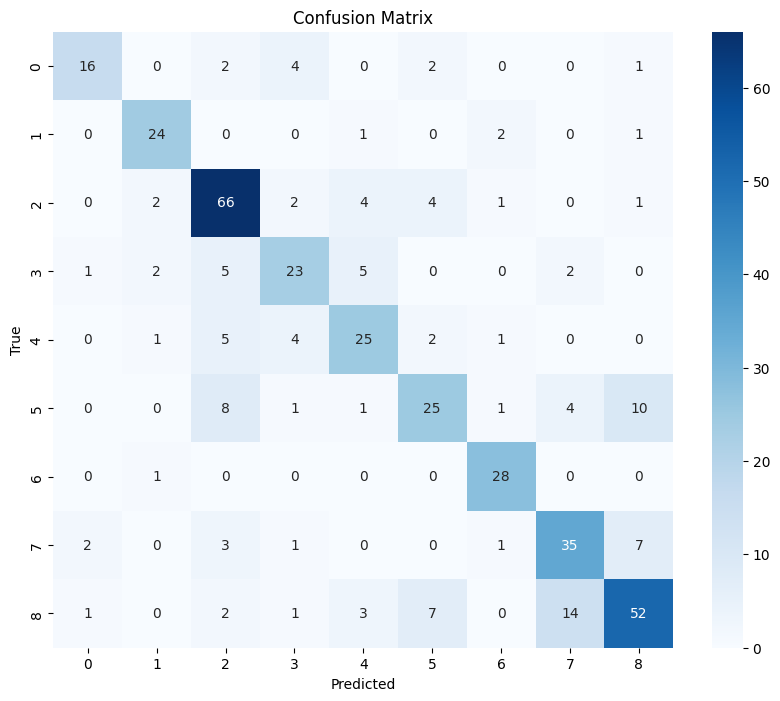

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

predictions = trainer.predict(val_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=3, target_names=[str(c) for c in le.classes_]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

**Перейдем к более крупной модели**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments
)
from transformers.trainer_utils import IntervalStrategy
from torch.nn import CrossEntropyLoss
import numpy as np
import torch
from datasets import Dataset

train_df, val_df = train_test_split(
    df_final,
    test_size=0.2,
    random_state=42,
    stratify=df_final["label"]
)

print("Train:", train_df.shape, "\nVal:", val_df.shape)

MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
val_df['label'] = le.transform(val_df['label'])

NUM_LABELS = len(le.classes_)
print("NUM_LABELS:", NUM_LABELS)


def preprocess(batch):
    texts = [str(x) for x in batch["text_clean"]]
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

train_ds = train_ds.map(preprocess, batched=True)
val_ds = val_ds.map(preprocess, batched=True)

train_ds = train_ds.rename_column("label", "labels").with_format("torch")
val_ds = val_ds.rename_column("label", "labels").with_format("torch")


classes = np.arange(NUM_LABELS)
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["label"].values
)

weights = np.asarray(weights, dtype=np.float32)
class_weights = torch.tensor(weights, dtype=torch.float32, device="cuda")
print("class_weights:", class_weights)


model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'f1_macro': f1_score(labels, predictions, average='macro'),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted')
    }

training_args = TrainingArguments(
    output_dir="./rubert_results",
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=8,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    load_best_model_at_end=False,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    fp16=True,
    push_to_hub=False,
    report_to="none",
    seed=42
)

def custom_loss(model, inputs, return_outputs=False, **kwargs):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
    loss = loss_fct(logits.view(-1, NUM_LABELS), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.compute_loss = custom_loss

trainer.train()
trainer.save_model("./rubert_results/best_model/cross_entropy")

Train: (1665, 2) 
Val: (417, 2)
NUM_LABELS: 9


Map:   0%|          | 0/1665 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

class_weights: tensor([1.8500, 1.6228, 0.5781, 1.2333, 1.2092, 0.9343, 1.6087, 0.9439, 0.5799],
       device='cuda:0')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2197671850.py:141: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,Precision,Recall
1,2.066800,1.756934,0.429257,0.371943,0.303961,0.485663,0.429257
2,1.438600,1.155082,0.659472,0.654597,0.653385,0.678383,0.659472
3,0.903600,0.934682,0.702638,0.700759,0.711459,0.736207,0.702638
4,0.595000,0.799216,0.721823,0.723711,0.743354,0.733414,0.721823
5,0.389800,0.788630,0.724221,0.728837,0.748788,0.743375,0.724221
6,0.244200,0.797328,0.724221,0.725686,0.740721,0.729814,0.724221
7,0.176000,0.807255,0.743405,0.744411,0.756937,0.750920,0.743405


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Максимальный f1 Weight. на 7 эпохе. Забираем веса с данного чекпоинта

Classification Report:

              precision    recall  f1-score   support

           0      0.762     0.640     0.696        25
           1      0.962     0.893     0.926        28
           2      0.744     0.800     0.771        80
           3      0.686     0.632     0.658        38
           4      0.750     0.789     0.769        38
           5      0.552     0.640     0.593        50
           6      0.933     0.966     0.949        29
           7      0.673     0.755     0.712        49
           8      0.818     0.675     0.740        80

    accuracy                          0.743       417
   macro avg      0.764     0.754     0.757       417
weighted avg      0.751     0.743     0.744       417



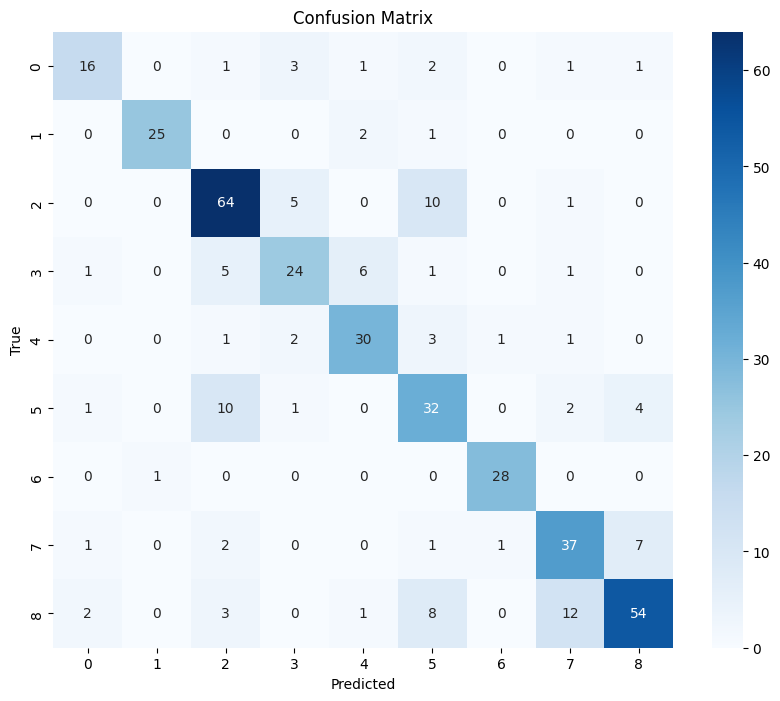

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

predictions = trainer.predict(val_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=3, target_names=[str(c) for c in le.classes_]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Попробую использовать Focal Loss вместо CrossEntropy

In [10]:
import torch
import torch.nn as nn
from transformers import Trainer

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments
)
from transformers.trainer_utils import IntervalStrategy
from torch.nn import CrossEntropyLoss
import numpy as np
import torch
from datasets import Dataset


train_df, val_df = train_test_split(
    df_final,
    test_size=0.2,
    random_state=42,
    stratify=df_final["label"]
)

print("Train:", train_df.shape, "\nVal:", val_df.shape)


MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
val_df['label'] = le.transform(val_df['label'])

NUM_LABELS = len(le.classes_)
print("NUM_LABELS:", NUM_LABELS)


def preprocess(batch):
    texts = [str(x) for x in batch["text_clean"]]
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

train_ds = train_ds.map(preprocess, batched=True)
val_ds = val_ds.map(preprocess, batched=True)

train_ds = train_ds.rename_column("label", "labels").with_format("torch")
val_ds = val_ds.rename_column("label", "labels").with_format("torch")


model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'f1_macro': f1_score(labels, predictions, average='macro'),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted')
    }


training_args = TrainingArguments(
    output_dir="./rubert_results",
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=8,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    load_best_model_at_end=False,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    fp16=True,
    push_to_hub=False,
    report_to="none",
    seed=42
)


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction="none")

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss


def custom_loss(model, inputs, return_outputs=False, **kwargs):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = FocalLoss(alpha=1, gamma=2)
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.compute_loss = custom_loss

trainer.train()
trainer.save_model("./rubert_results/best_model/focal_loss")

Train: (1665, 2) 
Val: (417, 2)
NUM_LABELS: 9


Map:   0%|          | 0/1665 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2292688051.py:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,Precision,Recall
1,1.526900,1.062832,0.503597,0.432580,0.373932,0.582398,0.503597
2,0.805600,0.619217,0.673861,0.660948,0.664784,0.695977,0.673861
3,0.452400,0.595802,0.695444,0.698745,0.716661,0.738282,0.695444
4,0.245300,0.510271,0.717026,0.715866,0.735853,0.723415,0.717026
5,0.140700,0.526494,0.721823,0.722059,0.737953,0.730180,0.721823
6,0.072600,0.568657,0.731415,0.730013,0.745575,0.731291,0.731415
7,0.038700,0.593311,0.724221,0.725395,0.747402,0.734539,0.724221
8,0.028700,0.598927,0.741007,0.740413,0.759332,0.742387,0.741007


Лучший f1 Weigh. на 8 эпохе. Немного уступает результату выше

Classification Report:

              precision    recall  f1-score   support

           0      0.680     0.680     0.680        25
           1      0.964     0.964     0.964        28
           2      0.753     0.725     0.739        80
           3      0.659     0.763     0.707        38
           4      0.756     0.816     0.785        38
           5      0.571     0.560     0.566        50
           6      0.935     1.000     0.967        29
           7      0.673     0.714     0.693        49
           8      0.786     0.688     0.733        80

    accuracy                          0.741       417
   macro avg      0.753     0.768     0.759       417
weighted avg      0.742     0.741     0.740       417



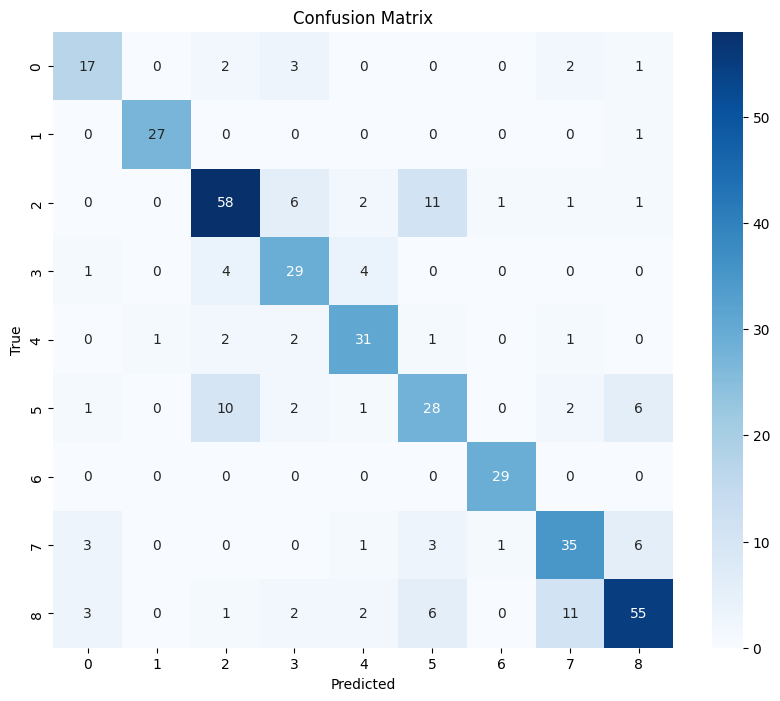

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

predictions = trainer.predict(val_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=3, target_names=[str(c) for c in le.classes_]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Инференс

In [ ]:
df_test = pd.read_csv('/content/test.csv')

In [ ]:
df_test.head()

,text
0,Советую продавца
1,По вашему это платье???? Это узкая кофта !!!! ...
2,Жуткая синтетика. Неприятная ткань. Летом не п...
3,"Джемперок так себе на хилую четверку,запах гол..."
4,"обычная х/б рубашка.не плотная,просвечивает ни..."


In [ ]:
import re
import emoji
import pandas as pd
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
import torch
import os

os.environ["WANDB_DISABLED"] = "true"

URL_RE = re.compile(r'https?://\S+')
HTML_RE = re.compile(r'<[^>]+>')
EMAIL_RE = re.compile(r'\S+@\S+')
PHONE_RE = re.compile(r'\+?\d[\d\-\s]{5,}\d')

def clean_text(t: str) -> str:
    if pd.isna(t):
        return ''
    t = str(t)
    t = t.strip()
    t = URL_RE.sub(' ', t)
    t = HTML_RE.sub(' ', t)
    t = EMAIL_RE.sub(' ', t)
    t = PHONE_RE.sub(' ', t)
    t = emoji.replace_emoji(t, replace=' ')
    t = re.sub(r'\s+', ' ', t)
    return t

df_test["text_clean"] = df_test["text"].map(clean_text)
df_test = df_test[["text_clean"]].dropna().reset_index(drop=True)
print("Test shape:", df_test.shape)

model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained("./rubert_results/best_model/cross_entropy")

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.encodings = tokenizer(
            texts.tolist(),
            truncation=True,
            padding=True,
            max_length=max_len
        )

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

test_dataset = TestDataset(df_test["text_clean"], tokenizer)

trainer = Trainer(model=model, tokenizer=tokenizer)

predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)

df_test["label"] = pred_labels

Test shape: (7276, 1)


/tmp/ipython-input-3071395599.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
df_test.to_csv("test_predicted.csv", index=False)

In [ ]:
df_test['label'].value_counts()

,count
label,
2,2662
8,1868
5,940
7,632
4,570
3,390
0,160
1,31
6,23


Замер результата

In [ ]:
import time
import numpy as np
import torch

start = time.perf_counter()

predictions = trainer.predict(test_dataset)

end = time.perf_counter()
total_time = end - start

num_samples = len(test_dataset)
avg_time_per_sample = total_time / num_samples

print(f"Всего времени: {total_time:.2f} сек")
print(f"Среднее на 1 пример: {avg_time_per_sample:.4f} сек")

Всего времени: 15.47 сек
Среднее на 1 пример: 0.0021 сек


In [5]:
label_to_category = {
    0: "бытовая техника",
    1: "обувь",
    2: "одежда",
    3: "посуда",
    4: "текстиль",
    5: "товары для детей",
    6: "украшения и аксессуары",
    7: "электроника",
    8: "нет товара"
}

df_test['category'] = df_test['label'].map(label_to_category)

print("Первые 10 строк с преобразованными метками:")
print(df_test[['text_clean', 'label', 'category']].head(10))

print("\nРаспределение по категориям:")
print(df_test['category'].value_counts())

Первые 10 строк с преобразованными метками:
                                          text_clean  label          category
0                                   Советую продавца      8        нет товара
1  По вашему это платье???? Это узкая кофта !!!! ...      2            одежда
2  Жуткая синтетика. Неприятная ткань. Летом не п...      4          текстиль
3  Джемперок так себе на хилую четверку,запах гол...      2            одежда
4  обычная х/б рубашка.не плотная,просвечивает ни...      2            одежда
5  Свитер очень колется, лично я не смогла его из...      3            посуда
6  По размеру не подошёл , хотя читала отзывы, оч...      2            одежда
7  размер 5xl на российский размер 60 совсем не п...      2            одежда
8              Блузка не пришла, заказывали 31 июня.      5  товары для детей
9  товар не пришел деньги не вернули.продавец не ...      8        нет товара

Распределение по категориям:
category
одежда                    2662
нет товара                18

In [6]:
submission_df = df_test['category'].copy()

# Сохраняем в CSV
submission_df.to_csv('submission.csv', index=False)

print(f"Всего записей: {len(submission_df)}")

Всего записей: 7276
